# Data Science Project 3

- Student Name: Natalya Doris
- Student Pace: Flex / 40 weeks
- Scheduled Project Review Date / Time: Thurs, Sept 16 / 12pm
- Instructor Name: Abhineet Kulkarni

## Setup, EDA, Preprocessing

In [439]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, \
cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, \
MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

### Load in Data

In [440]:
df = pd.read_csv('data/investments_VC.csv', encoding = "ISO-8859-1")

### Basic Cleaning

In [441]:
# getting rid of extra spaces in market and funding_total_usd
df = df.rename(columns={' market ': 'market', 
                        ' funding_total_usd ': 'funding_total_usd'})

Dropping irrelevant columns:

In [442]:
df = df.drop(columns=['permalink', 'homepage_url', 'category_list', 
                          'founded_quarter', 'post_ipo_equity',  
                          'post_ipo_debt', 'secondary_market'], 
                 axis=1)

In [443]:
# converting to float
df['funding_total_usd'][~df['funding_total_usd'].isnull()] = \
    [float(num.replace(" ", "0").replace(",", "0").replace("-", "0")) \
     for num in df['funding_total_usd'][~df['funding_total_usd'].isnull()]]

Dropping duplicates, if any:

In [444]:
df = df.drop_duplicates()

In [445]:
df['status'].value_counts()

operating    41829
acquired      3692
closed        2603
Name: status, dtype: int64

### Exploratory Analysis - Full Dataset

In [446]:
data = df

In [447]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49439 entries, 0 to 49438
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  49437 non-null  object 
 1   market                45470 non-null  object 
 2   funding_total_usd     49438 non-null  object 
 3   status                48124 non-null  object 
 4   country_code          44165 non-null  object 
 5   state_code            30161 non-null  object 
 6   region                44165 non-null  object 
 7   city                  43322 non-null  object 
 8   funding_rounds        49438 non-null  float64
 9   founded_at            38554 non-null  object 
 10  founded_month         38482 non-null  object 
 11  founded_year          38482 non-null  float64
 12  first_funding_at      49438 non-null  object 
 13  last_funding_at       49438 non-null  object 
 14  seed                  49438 non-null  float64
 15  venture            

,name,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,private_equity,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,#waywire,News,1.705e+09,acquired,USA,NY,New York City,New York,1.0,2012-06-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,&TV Communications,Games,4e+09,operating,USA,CA,Los Angeles,Los Angeles,2.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,'Rock' Your Paper,Publishing,4e+06,operating,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,(In)Touch Network,Electronics,1.5e+09,operating,GBR,NaN,London,London,1.0,2011-04-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-R- Ranch and Mine,Tourism,6e+06,operating,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [448]:
df.describe()

,funding_rounds,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,49438.000000,38482.000000,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04
mean,1.696205,2007.359129,2.173215e+05,7.501051e+06,6.163322e+03,1.302213e+05,2.336410e+04,1.888157e+06,6.541898e+04,1.628453e+05,2.074286e+06,7.074227e+03,1.243955e+06,1.492891e+06,1.205356e+06,7.375261e+05,3.424682e+05,1.697692e+05,5.767067e+04,1.423197e+04
std,1.294213,7.579203,1.056985e+06,2.847112e+07,1.999048e+05,2.981404e+06,1.432046e+06,1.382046e+08,6.582908e+05,5.612088e+06,3.167231e+07,4.282166e+05,5.531974e+06,7.472704e+06,7.993592e+06,9.815218e+06,5.406915e+06,6.277905e+06,5.252312e+06,2.716865e+06
min,1.000000,1902.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,2006.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,2012.000000,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,18.000000,2014.000000,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,3.007950e+10,6.359026e+07,7.505000e+08,3.500000e+09,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08


In [449]:
data.isnull().sum()

name                        2
market                   3969
funding_total_usd           1
status                   1315
country_code             5274
state_code              19278
region                   5274
city                     6117
funding_rounds              1
founded_at              10885
founded_month           10957
founded_year            10957
first_funding_at            1
last_funding_at             1
seed                        1
venture                     1
equity_crowdfunding         1
undisclosed                 1
convertible_note            1
debt_financing              1
angel                       1
grant                       1
private_equity              1
product_crowdfunding        1
round_A                     1
round_B                     1
round_C                     1
round_D                     1
round_E                     1
round_F                     1
round_G                     1
round_H                     1
dtype: int64

In [450]:
data['founded_at'].head()

0    2012-06-01
1           NaN
2    2012-10-26
3    2011-04-01
4    2014-01-01
Name: founded_at, dtype: object

In [451]:
data['region'].value_counts()

SF Bay Area      6804
New York City    2577
Boston           1837
London           1588
Los Angeles      1389
                 ... 
Carlisle            1
Hellerup            1
Tashkent            1
Paignton            1
TTO - Other         1
Name: region, Length: 1089, dtype: int64

In [452]:
data['city'].value_counts()

San Francisco        2615
New York             2334
London               1257
Palo Alto             597
Austin                583
                     ... 
Plouzané                1
West Chicago            1
North Kansas City       1
Marquette               1
Warrenville             1
Name: city, Length: 4188, dtype: int64

In [453]:
data['state_code'].value_counts()

CA    9917
NY    2914
MA    1969
TX    1466
WA     974
      ... 
MB      13
AK      12
NB       8
SK       4
PE       2
Name: state_code, Length: 61, dtype: int64

In [454]:
data['country_code'].value_counts()

USA    28793
GBR     2642
CAN     1405
CHN     1239
DEU      968
       ...  
TTO        1
SYC        1
JEY        1
MAF        1
UZB        1
Name: country_code, Length: 115, dtype: int64

In [455]:
# inspecting market feature - lots of catgories
print("Number of unique markets: ", len(set(data['market'])))
print("Markets with more than 200 companies: ",      
      str(sum(data['market'].value_counts() >= 200)))

Number of unique markets:  754
Markets with more than 200 companies:  39


<AxesSubplot:>

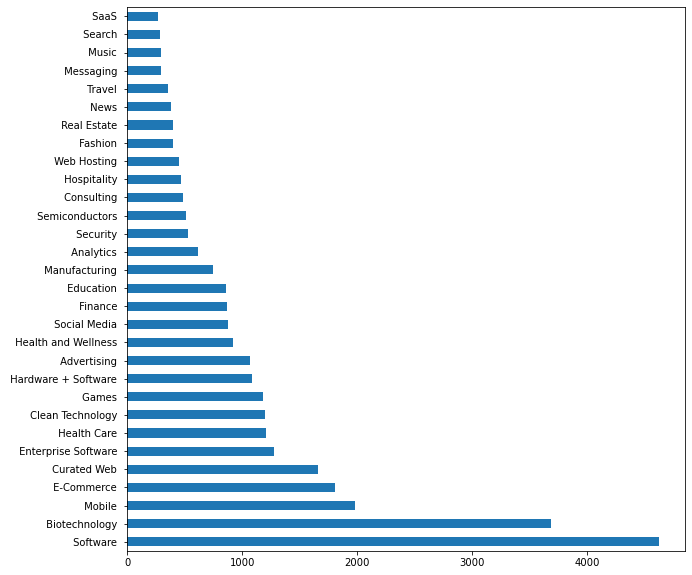

In [456]:
fig, ax = plt.subplots(figsize = (10,10))
data['market'].value_counts()[:30].plot(kind='barh')

In [457]:
# same deal with region
print("Number of unique regions: ", len(set(data['region'])))
print("Regions with more than 200 companies: ",      
      str(sum(data['region'].value_counts() >= 200)))

Number of unique regions:  1090
Regions with more than 200 companies:  44


<AxesSubplot:>

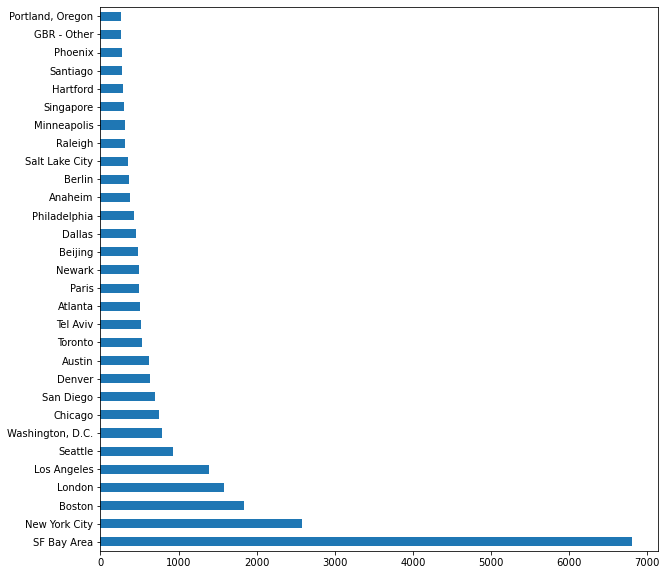

In [458]:
fig, ax = plt.subplots(figsize = (10,10))
data['region'].value_counts()[:30].plot(kind='barh')

array([[<AxesSubplot:title={'center':'equity_crowdfunding'}>]],
      dtype=object)

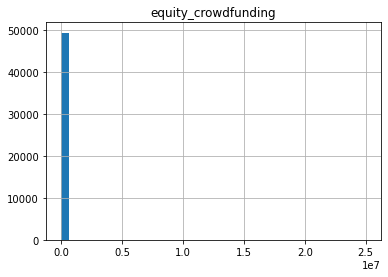

In [459]:
data.hist('equity_crowdfunding', bins=40) 
# there are some very skewed columns in the funding area

### Preprocessing & Feature Engineering

In [460]:
data.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'founded_month', 'founded_year', 'first_funding_at', 'last_funding_at',
       'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'],
      dtype='object')

#### Missing Values

* I am removing rows with missing status or company name. 
* I am also dropping rows with a missing founded_year because this feature has high importance in many of the models & thus would prefer not to impute at risk of skewing the model. I tried both dropping and keeping  the missing founded_years (imputed). The proportion of companies in each status category & model results are fairly similar with & without imputing the median of year so I am comfortable dropping these rows.

In [461]:
data = data.dropna(subset=['status', 'name', 'founded_year'])
data.isnull().sum()

name                        0
market                   1801
funding_total_usd           0
status                      0
country_code             2936
state_code              13332
region                   2936
city                     3357
funding_rounds              0
founded_at                  0
founded_month               0
founded_year                0
first_funding_at            0
last_funding_at             0
seed                        0
venture                     0
equity_crowdfunding         0
undisclosed                 0
convertible_note            0
debt_financing              0
angel                       0
grant                       0
private_equity              0
product_crowdfunding        0
round_A                     0
round_B                     0
round_C                     0
round_D                     0
round_E                     0
round_F                     0
round_G                     0
round_H                     0
dtype: int64

In [462]:
len(data)

37563

In [463]:
# filling categoricals
data = data.fillna(value={'market': 'other', 'country_code': 'other', 
                          'region': 'other', 'city': 'other', 
                          'state_code': 'other'})

10th percentile of founded_year:  2000.0
Num Rows before 2000:  3518


34045

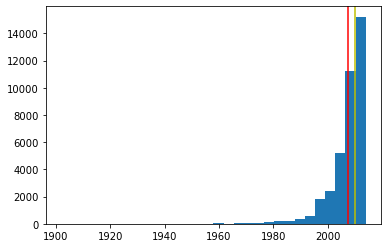

In [464]:
# distribution of non NA years 
plt.hist(data['founded_year'][~data['founded_year'].isnull()], bins=30)
plt.axvline(x=np.nanmean(data['founded_year']), color='r')
plt.axvline(x=np.nanmedian(data['founded_year']), color='y')

p10 = np.percentile(data['founded_year'][~data['founded_year'].isnull()], 10)
print("10th percentile of founded_year: ", p10)

#10th percentile year is 2000, we will subset for startups founded on or after 2000
print("Num Rows before 2000: ", len(data[data['founded_year'] < 2000]))
data = data[data['founded_year'] >= 2000].reset_index(drop=True)
len(data)

In [465]:
len(df[(df['founded_year'] < 2000) & (df['status'] != 'operating')])

838

Date data - convert to datetime:

In [466]:
data['founded_at'] = [datetime.strptime(day, '%Y-%m-%d') for day \
                      in data['founded_at'][~data['founded_at'].isnull()]]
data['first_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                            in data['first_funding_at']]
data['last_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                            in data['last_funding_at']]
data['founded_month'] = [datetime.strptime(mth, "%Y-%m").month for mth in data['founded_month']]

Fill year & founded_at with simple imputer (only if not removing NaN rows). Since the data is skewed (see plot above), we will use median rather than mean.

In [467]:
# uncomment the below to impute founded_year with mean, only if we are not 
# dropping nans for this feature

#imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

#data['founded_year'] = imp_median.fit_transform(data[['founded_year']])
#data['founded_at'] = imp_median.fit_transform(data[['founded_at']])

In [468]:
data['founded_at'] = pd.to_datetime(data['founded_at'])
data['founded_year'] = [day.year for day in data['founded_at']]

In [469]:
data['founded_at'].value_counts()

2012-01-01    2100
2011-01-01    2096
2010-01-01    1810
2009-01-01    1561
2013-01-01    1535
              ... 
2004-04-25       1
2009-08-12       1
2014-08-04       1
2002-08-02       1
2010-11-06       1
Name: founded_at, Length: 2935, dtype: int64

In [470]:
data.isna().sum()

name                    0
market                  0
funding_total_usd       0
status                  0
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
founded_month           0
founded_year            0
first_funding_at        0
last_funding_at         0
seed                    0
venture                 0
equity_crowdfunding     0
undisclosed             0
convertible_note        0
debt_financing          0
angel                   0
grant                   0
private_equity          0
product_crowdfunding    0
round_A                 0
round_B                 0
round_C                 0
round_D                 0
round_E                 0
round_F                 0
round_G                 0
round_H                 0
dtype: int64

Basic data cleaning:

In [471]:
# getting rid of extra spaces in market, city, state code, region
data['market'] = [x.strip() for x in data['market']]
data['country_code'] = [x.strip() for x in data['country_code']]
data['state_code'] = [x.strip() for x in data['state_code']]
data['region'] = [x.strip() for x in data['region']]
data['city'] = [x.strip() for x in data['city']]

In [472]:
data.dtypes

name                            object
market                          object
funding_total_usd               object
status                          object
country_code                    object
state_code                      object
region                          object
city                            object
funding_rounds                 float64
founded_at              datetime64[ns]
founded_month                    int64
founded_year                     int64
first_funding_at                object
last_funding_at                 object
seed                           float64
venture                        float64
equity_crowdfunding            float64
undisclosed                    float64
convertible_note               float64
debt_financing                 float64
angel                          float64
grant                          float64
private_equity                 float64
product_crowdfunding           float64
round_A                        float64
round_B                  

In [473]:
# need to convert this data type to integer
data['funding_total_usd'].value_counts()

0.000000e+00    5632
1.000000e+09     627
1.000000e+08     582
5.000000e+08     573
4.000000e+06     466
                ... 
3.012099e+11       1
1.045077e+08       1
1.000108e+12       1
1.609205e+09       1
2.068042e+11       1
Name: funding_total_usd, Length: 10560, dtype: int64

In [475]:
# data['funding_total_usd'] = [float(num.replace(" ", "0").replace(",", "0").\
#                                    replace("-", "0")) 
#                              for num in data['funding_total_usd']]
# data['funding_total_usd'].dtypes

#### Feature Engineering

In [476]:
# creating column that labels country as domestic or international
data['international'] = [0 if country=='USA' else 1 for country in data['country_code']]

In [477]:
# creating temporary columns to aid in calculation of time to first funding

data['founded_at_temp'] = [day.date() for day in data['founded_at']]
data['founded_at_temp'] = pd.to_datetime(data['founded_at_temp'], 
                                         format = '%Y-%m-%d')

data['first_funding_at_temp'] = pd.to_datetime(data['first_funding_at'], 
                                               format = '%Y-%m-%d', 
                                               errors='coerce')
data['last_funding_at_temp'] = pd.to_datetime(data['last_funding_at'], 
                                              format = '%Y-%m-%d', 
                                              errors='coerce')

data['time_to_first_funding'] = (data['first_funding_at_temp'] - \
                                 data['founded_at_temp']) / pd.Timedelta(days=365)

data['time_first_to_last_funding'] = (data['last_funding_at_temp'] - \
                                      data['first_funding_at_temp']) / pd.Timedelta(days=365)

In [478]:
# checking for nulls
print(data['first_funding_at'][data['time_to_first_funding'].isnull()])
print(data['last_funding_at'][data['time_first_to_last_funding'].isnull()])

1030     0020-06-14
4514     0019-11-20
9863     0201-01-01
20287    0007-05-13
21784    0001-05-14
Name: first_funding_at, dtype: object
1030     2013-06-01
4514     2013-04-01
9863     0201-01-01
20287    2014-09-25
21784    0001-05-14
Name: last_funding_at, dtype: object


In [479]:
# dropping these
data = data.dropna(subset=['time_to_first_funding'])

#### OPTIONAL - Outliers

408206869399.0
32338
34040


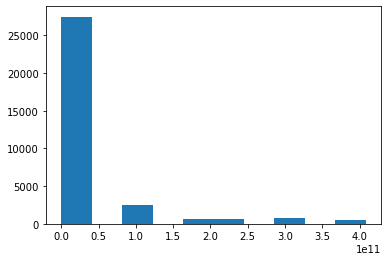

In [480]:
# Funding total USD
print(np.percentile(data['funding_total_usd'], 95))

plt.hist(data['funding_total_usd'][data['funding_total_usd'] < 408206869399.0])
print(len(data[data['funding_total_usd'] < 408206869399.0]))
print(len(data))

32301
31990
34040


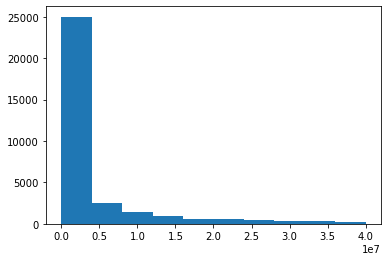

In [481]:
np.percentile(data['venture'], 95)

plt.hist(data['venture'][data['venture'] < 40000000.0])
print(len(data[data['venture'] < 40000000.0]))
print(len(data[(data['venture'] < 40000000.0) & 
               (data['funding_total_usd'] < 408206869399.0)]))
print(len(data))

In [482]:
### THIS DOESN'T HELP THE MODELS, SO I COMMENTED THIS OUT

In [483]:
# uncomment to remove outliers

#data = data[(data['venture'] < 40000000.0) & 
#            (data['funding_total_usd'] < 408206869399.0)].reset_index(drop=True)
#len(data)

#### Correlations

Based on the below, the strongest correlations occur between debt_financing and funding_total_usd, round_H and round_G, followed by venture and all of the rounds of funding

Text(0.5, 1.0, 'Heatmap of Correlation Between Attributes (Including Status)')

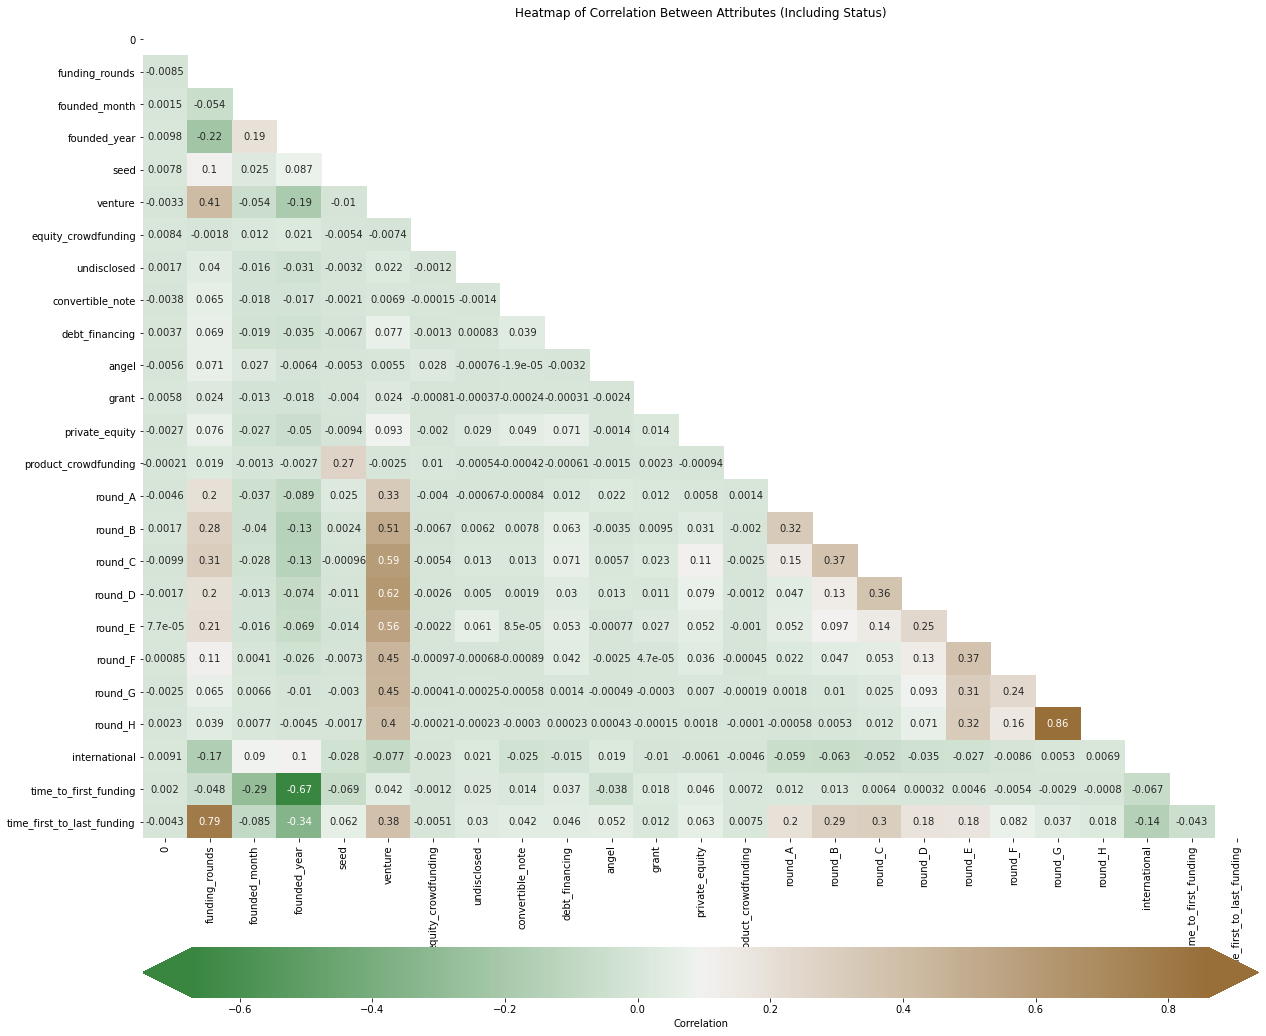

In [484]:
# with status
encoder = LabelEncoder()
heatmap_data = pd.concat([pd.Series(encoder.fit_transform(data['status'])), 
                          data.drop('status', axis=1)], axis=1)

# without status
#heatmap_data = data.drop('status', axis=1)

h_corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(20, 20))
mask = np.triu(np.ones_like(h_corr, dtype=bool))
cmap = sns.diverging_palette(130, 50, as_cmap=True)
cbar_kws = {'label': 'Correlation', 'orientation': 'horizontal', 
            'pad': .1, 'extend': 'both'}
sns.heatmap(data=h_corr, mask=mask, ax=ax, annot=True, cbar_kws=cbar_kws, cmap=cmap)
ax.set_title('Heatmap of Correlation Between Attributes (Including Status)')

In [485]:
#data_corr=data.drop(columns=['status'], axis=1).corr()
corr = h_corr.abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.set_index(['pairs'], inplace = True)
corr.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
corr.columns = ['cc']
corr.drop_duplicates(inplace=True)

corr[(corr['cc'] > 0.7) & (corr['cc'] < 1)]

,cc
pairs,
"(round_H, round_G)",0.859849
"(funding_rounds, time_first_to_last_funding)",0.793787


In [486]:
# dropping temp columns 
data = data.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                          'first_funding_at_temp', 'last_funding_at_temp', 
                          'founded_at_temp'], axis=1).reset_index(drop=True)

# creating csv file to work from
data.to_csv('data/final_working_data.csv')

In [487]:
# dropping columns with correlation coefficient greater than 0.7
data_uncorr = data.drop(columns=['round_H', 'time_first_to_last_funding'], 
                        axis=1).reset_index(drop=True)

#renaming full dataset
data_full = data

#### OPTIONAL - Binary Representation of Funding Rounds

In [488]:
# data['had_round_A'] = [0 if x==0 else 1 for x in data['round_A']]
# data['had_round_B'] = [0 if x==0 else 1 for x in data['round_B']]
# data['had_round_C'] = [0 if x==0 else 1 for x in data['round_C']]
# data['had_round_D'] = [0 if x==0 else 1 for x in data['round_D']]
# data['had_round_E'] = [0 if x==0 else 1 for x in data['round_E']]
# data['had_round_F'] = [0 if x==0 else 1 for x in data['round_F']]
# data['had_round_G'] = [0 if x==0 else 1 for x in data['round_G']]
# data['had_venture'] = [0 if x==0 else 1 for x in data['venture']]
# data['had_seed'] = [0 if x==0 else 1 for x in data['seed']]
# data['had_eq_crowdfunding'] = [0 if x==0 else 1 for x in data['equity_crowdfunding']]
# data['had_pd_crowdfunding'] = [0 if x==0 else 1 for x in data['product_crowdfunding']]
# data['had_angel'] = [0 if x==0 else 1 for x in data['angel']]
# data['had_grant'] = [0 if x==0 else 1 for x in data['grant']]
# data['had_pe'] = [0 if x==0 else 1 for x in data['private_equity']]
# data['had_convert'] = [0 if x==0 else 1 for x in data['convertible_note']]

## Functions

#### train_test_preprocess

In [489]:
''' 
Function to perform train_test_split and necessary preprocessing / scaling
'''

def train_test_preprocess(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # check that there are the same number of rows in X as values in y
    assert X_train.shape[0] == y_train.shape[0]
    
    # Categorizing features in preparation for scaling / encoding
    X_train_cat_eng = X_train.select_dtypes(include=['int64']).reset_index(drop=True)
    X_test_cat_eng = X_test.select_dtypes(include=['int64']).reset_index(drop=True)

    X_train_cont = X_train.select_dtypes(exclude=['object','int64']).reset_index(drop=True)
    X_test_cont = X_test.select_dtypes(exclude=['object','int64']).reset_index(drop=True)

    cat_columns = ['market', 'region']
    cat_train = X_train[cat_columns].reset_index(drop=True)
    cat_test = X_test[cat_columns].reset_index(drop=True)

    # Scale continuous variables using Min Max Scaler:
    scaler = MinMaxScaler() # instantiate MinMaxScaler

    ## TRAIN
    # Fit and transform X_train
    X_train_cont_scaled = scaler.fit_transform(X_train_cont)
    X_train_cont_scaled = pd.DataFrame(X_train_cont_scaled, columns=X_train_cont.columns)

    # One hot encode categoricals
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    encoded_train = ohe.fit_transform(cat_train).toarray()
    X_train_cat = pd.DataFrame(encoded_train, columns=ohe.get_feature_names(cat_train.columns))

    # Putting it all together:
    X_train_processed = pd.concat([X_train_cat, X_train_cont, X_train_cat_eng], axis=1)
    X_train_scaled = pd.concat([X_train_cat, X_train_cont_scaled, X_train_cat_eng], axis=1) 

    ## TEST
    # Scale continuous features
    X_test_cont_scaled = scaler.transform(X_test_cont)
    X_test_cont_scaled = pd.DataFrame(X_test_cont_scaled, columns=X_test_cont.columns)

    # One hot encoding categoricals
    encoded_test = ohe.transform(cat_test).toarray()
    X_test_cat = pd.DataFrame(encoded_test, columns=ohe.get_feature_names(cat_test.columns))

    # Putting it all together
    X_test_scaled = pd.concat([X_test_cat, X_test_cont_scaled, X_test_cat_eng], axis=1)
    X_test_processed = pd.concat([X_test_cat, X_test_cont, X_test_cat_eng], axis=1)
    
    return X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, y_train, y_test

#### print_scores

In [490]:
''' 
Function to print relevant scoring metrics
'''

def print_scores(y_train, y_hat_train, y_test, y_hat_test, binary=True):
    if binary:
        print('Training Recall: ', 
              recall_score(y_train, y_hat_train))
        print('Testing Recall: ', 
              recall_score(y_test, y_hat_test))
        print('\n')
        print('Training F1: ', 
              f1_score(y_train, y_hat_train))
        print('Testing F1: ', 
              f1_score(y_test, y_hat_test))
        print('\n')
        false_positive_rate, true_positive_rate, thresholds = \
        roc_curve(y_test, y_hat_test)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print('ROC AUC: ', roc_auc)
        print('PR AUC: ', average_precision_score(y_test, y_hat_test))
        print('\n')
        
    else:
        print('Training Recall (weighted avg): ', 
              recall_score(y_train, y_hat_train, average='weighted'))
        print('Testing Recall (weighted avg): ', 
              recall_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training Recall (macro avg): ', 
              recall_score(y_train, y_hat_train, average='macro'))
        print('Testing Recall (macro avg): ', 
              recall_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Training F1-Score (weighted avg): ', 
              f1_score(y_train, y_hat_train, average='weighted'))
        print('Testing F1-Score (weighted avg): ', 
              f1_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training F1-Score (macro avg): ', 
              f1_score(y_train, y_hat_train, average='macro'))
        print('Testing F1-Score (macro avg): ', 
              f1_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Testing Recall (failure class): ', 
              recall_score(y_test, y_hat_test, average=None, labels=[1]))
        print('\n')
    
    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

#### return_scores

In [491]:
''' 
Function that stores relevant scoring metrics
'''

def return_scores(y_train, y_hat_train, y_test, y_hat_test):
    r_train = recall_score(y_train, y_hat_train)
    r_test = recall_score(y_test, y_hat_test)
         
    f1_train = f1_score(y_train, y_hat_train)
    f1_test = f1_score(y_test, y_hat_test)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    pr_auc = average_precision_score(y_test, y_hat_test)
    
    ac_train = accuracy_score(y_train, y_hat_train)
    ac_test = accuracy_score(y_test, y_hat_test)
    
    return r_train, r_test, f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc

#### train_test_check

In [492]:
''' 
Function that checks new train & test splits for proper shape
'''

def train_test_check(X_train_processed, X_train_scaled, X_test_processed, 
                     X_test_scaled, y_train, y_test):
    
    assert X_train_processed.shape[0] == y_train.shape[0]
    assert X_train_scaled.shape[0] == y_train.shape[0]
    
    assert X_test_processed.shape[0] == y_test.shape[0]
    assert X_test_scaled.shape[0] == y_test.shape[0]

    print("There are {} features in train set".format(len(X_train_processed.columns)))
    print("There are {} features in test set".format(len(X_test_processed.columns)))
    print('\n')

    print("There are {} features in train set (scaled)".format(len(X_train_scaled.columns)))
    print("There are {} features in test set (scaled)".format(len(X_test_scaled.columns)))
    print('\n')
    
    print(f"y_train is a Series with {y_train.shape[0]} values")
    print('\n')
    print("target breakdown: ", y_train.value_counts(normalize=True))

    display(X_train_processed.head())
    display(X_train_scaled.head())

#### correlation_check

In [493]:
''' 
Function that checks for excessive correlations across features
'''
def correlation_check(X_train_processed):
    
    df_corr=X_train_processed.corr()

    df = df_corr.abs().stack().reset_index().sort_values(0, ascending=False)
    df['pairs'] = list(zip(df.level_0, df.level_1))
    df.set_index(['pairs'], inplace = True)
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    # cc for correlation coefficient
    df.columns = ['cc']
    df.drop_duplicates(inplace=True)

    display(df[(df.cc>.5) & (df.cc<1)])

# Acquired or Closed Dataset

In [494]:
data_ac = df[df['status'] != 'operating']

## EDA / Preprocessing

In [495]:
data_ac.isnull().sum()

name                       2
market                   611
funding_total_usd          1
status                  1315
country_code             835
state_code              2582
region                   835
city                     951
funding_rounds             1
founded_at              1720
founded_month           1725
founded_year            1725
first_funding_at           1
last_funding_at            1
seed                       1
venture                    1
equity_crowdfunding        1
undisclosed                1
convertible_note           1
debt_financing             1
angel                      1
grant                      1
private_equity             1
product_crowdfunding       1
round_A                    1
round_B                    1
round_C                    1
round_D                    1
round_E                    1
round_F                    1
round_G                    1
round_H                    1
dtype: int64

In [496]:
len(data_ac)

7610

In [497]:
data_ac = data_ac.dropna(subset=['status', 'name'])
len(data_ac)

6294

In [498]:
data_ac.dtypes

name                     object
market                   object
funding_total_usd        object
status                   object
country_code             object
state_code               object
region                   object
city                     object
funding_rounds          float64
founded_at               object
founded_month            object
founded_year            float64
first_funding_at         object
last_funding_at          object
seed                    float64
venture                 float64
equity_crowdfunding     float64
undisclosed             float64
convertible_note        float64
debt_financing          float64
angel                   float64
grant                   float64
private_equity          float64
product_crowdfunding    float64
round_A                 float64
round_B                 float64
round_C                 float64
round_D                 float64
round_E                 float64
round_F                 float64
round_G                 float64
round_H 

In [499]:
# converting to float
data_ac['funding_total_usd'] = [float(num) for num in data_ac['funding_total_usd']]

In [500]:
data_ac['status'].value_counts(normalize=True)

acquired    0.58659
closed      0.41341
Name: status, dtype: float64

In [501]:
# filling categoricals
data_ac = data_ac.fillna(value={'market': 'other', 'country_code': 'other', 
                                'region': 'other', 'city': 'other', 
                                'state_code': 'other'})

1st percentile of founded_year:  1982.0
Num Rows before 1980:  35


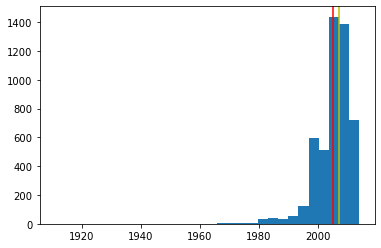

In [502]:
# distribution of non NA years 
plt.hist(data_ac['founded_year'][~data_ac['founded_year'].isnull()], bins=30)
plt.axvline(x=np.nanmean(data_ac['founded_year']), color='r')
plt.axvline(x=np.nanmedian(data_ac['founded_year']), color='y')

p1 = np.percentile(data_ac['founded_year'][~data_ac['founded_year'].isnull()], 1)
print("1st percentile of founded_year: ", p1)

#1980 looks like a good cutoff point
print("Num Rows before 1980: ", len(data_ac[data_ac['founded_year'] < 1980]))
data_ac = data_ac[data_ac['founded_year'] >= 1980].reset_index(drop=True)

In [503]:
data_ac['founded_at'] = [datetime.strptime(day, '%Y-%m-%d') for day \
                         in data_ac['founded_at'][~data_ac['founded_at'].isnull()]]
data_ac['first_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                               in data_ac['first_funding_at']]
data_ac['last_funding_at'] = [datetime.strptime(day, '%Y-%m-%d').date() for day \
                              in data_ac['last_funding_at']]
data_ac['founded_month'] = [datetime.strptime(mth, "%Y-%m").month for mth in data_ac['founded_month']]

In [504]:
# imputing median for day, then pulling founded year and month from that
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

data_ac['founded_at'] = imp_median.fit_transform(data_ac[['founded_at']])

data_ac['founded_at'] = pd.to_datetime(data_ac['founded_at'])
data_ac['founded_year'] = [day.year for day in data_ac['founded_at']]
data_ac['founded_month'] = [day.month for day in data_ac['founded_at']]

In [505]:
# creating column that labels country as domestic or international
data_ac['international'] = [0 if country=='USA' else 1 for country in data_ac['country_code']]

In [506]:
# creating temporary columns to aid in calcuation of time to first funding

data_ac['founded_at_temp'] = [day.date() for day in data_ac['founded_at']]
data_ac['founded_at_temp'] = pd.to_datetime(data_ac['founded_at_temp'], 
                                            format = '%Y-%m-%d')

data_ac['first_funding_at_temp'] = pd.to_datetime(data_ac['first_funding_at'], 
                                                  format = '%Y-%m-%d', 
                                                  errors='coerce')
data_ac['last_funding_at_temp'] = pd.to_datetime(data_ac['last_funding_at'], 
                                                 format = '%Y-%m-%d', 
                                                 errors='coerce')

data_ac['time_to_first_funding'] = (data_ac['first_funding_at_temp'] - \
                                    data_ac['founded_at_temp']) / pd.Timedelta(days=365)

data_ac['time_first_to_last_funding'] = (data_ac['last_funding_at_temp'] - \
                                         data_ac['first_funding_at_temp']) / pd.Timedelta(days=365)

In [507]:
# checking for nulls
print(data_ac['first_funding_at'][data_ac['time_to_first_funding'].isnull()])
print(data_ac['last_funding_at'][data_ac['time_first_to_last_funding'].isnull()])

3697    0011-11-14
Name: first_funding_at, dtype: object
3697    2012-07-24
Name: last_funding_at, dtype: object


In [508]:
data_ac = data_ac.dropna(subset=['time_to_first_funding']).reset_index(drop=True)

In [509]:
# getting rid of extra spaces

data_ac['market'] = [x.strip() for x in data_ac['market']]
data_ac['country_code'] = [x.strip() for x in data_ac['country_code']]
data_ac['state_code'] = [x.strip() for x in data_ac['state_code']]
data_ac['region'] = [x.strip() for x in data_ac['region']]
data_ac['city'] = [x.strip() for x in data_ac['city']]

Text(0.5, 1.0, 'Heatmap of Correlation Between Attributes (Including Status)')

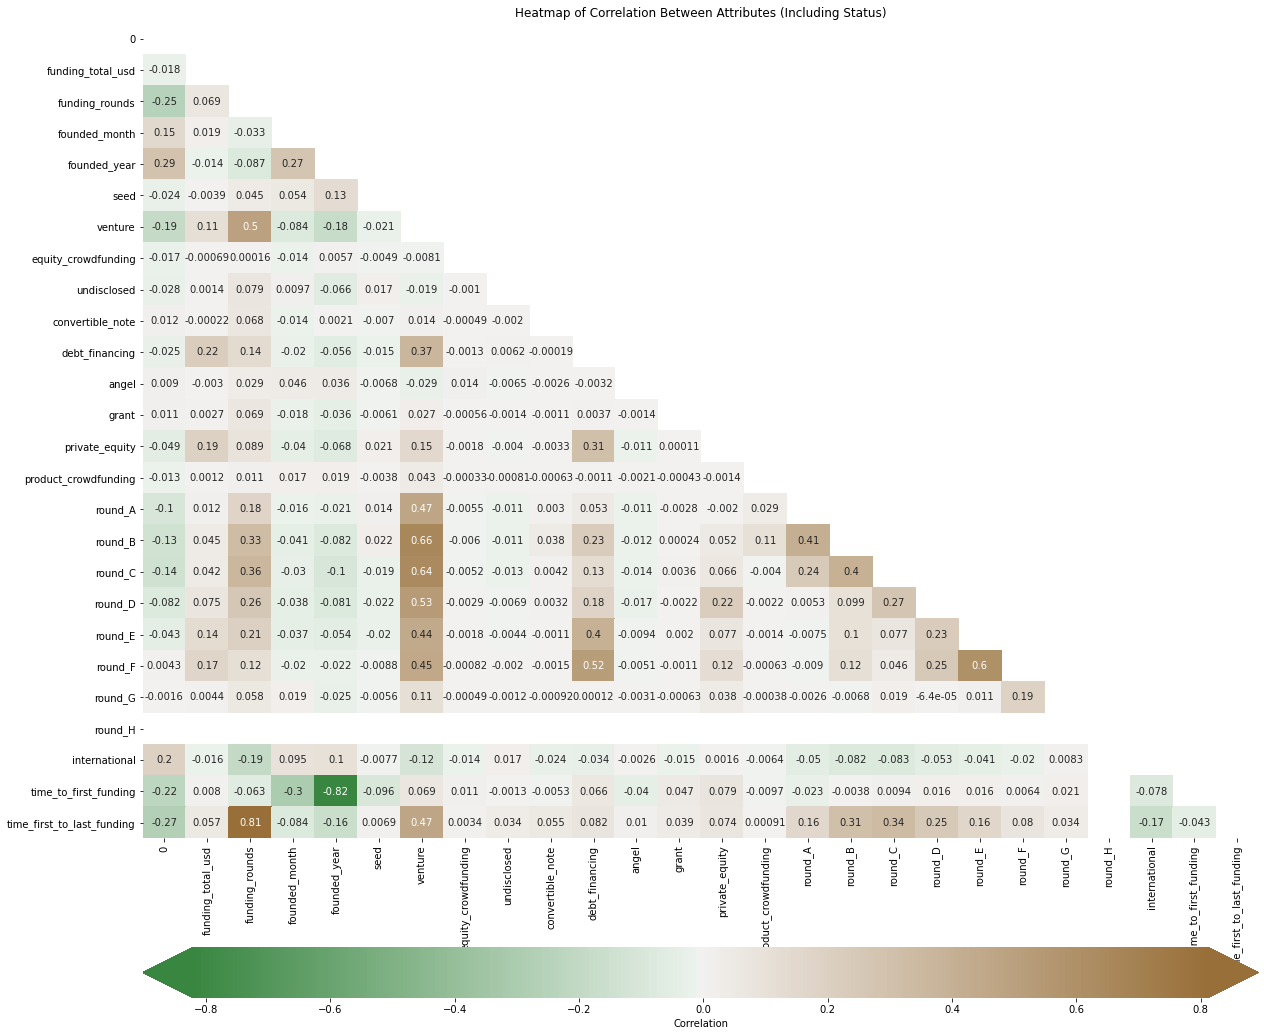

In [510]:
# correlation check
# with status
encoder = LabelEncoder()
heatmap_data = pd.concat([pd.Series(encoder.fit_transform(data_ac['status'])), 
                          data_ac.drop('status', axis=1)], axis=1)

# without status
#heatmap_data = data.drop('status', axis=1)

h_corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(20, 20))
mask = np.triu(np.ones_like(h_corr, dtype=bool))
cmap = sns.diverging_palette(130, 50, as_cmap=True)
cbar_kws = {'label': 'Correlation', 'orientation': 'horizontal', 
            'pad': .1, 'extend': 'both'}
sns.heatmap(data=h_corr, mask=mask, ax=ax, annot=True, cbar_kws=cbar_kws, cmap=cmap)
ax.set_title('Heatmap of Correlation Between Attributes (Including Status)')

In [511]:
corr = h_corr.abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.set_index(['pairs'], inplace = True)
corr.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
corr.columns = ['cc']
corr.drop_duplicates(inplace=True)

corr[(corr['cc'] > 0.7) & (corr['cc'] < 1)]

,cc
pairs,
"(time_to_first_funding, founded_year)",0.819908
"(funding_rounds, time_first_to_last_funding)",0.812019


In [512]:
# reducing number of categories in market & region

print(sum(data_ac['market'].value_counts() >= 15))
data_ac['market'][data_ac['market'].map(data_ac['market'].value_counts()) < 15] = 'other'
print(data_ac['market'].value_counts())

print(sum(data_ac['region'].value_counts() >= 60))
data_ac['region'][data_ac['region'].map(data_ac['region'].value_counts()) < 60] = 'other'
print(data_ac['region'].value_counts())

48
other                    1162
Software                  569
Curated Web               347
Mobile                    281
Enterprise Software       200
Biotechnology             189
Advertising               173
Games                     172
E-Commerce                164
Social Media              136
Hardware + Software       100
Semiconductors             96
Security                   92
Web Hosting                84
Clean Technology           78
Health Care                75
Finance                    71
Analytics                  59
Messaging                  55
Search                     54
News                       47
Music                      45
Education                  43
Public Relations           42
Video                      41
Travel                     40
Networking                 38
Photography                36
Social Network Media       34
Consulting                 33
Health and Wellness        32
SaaS                       29
Sports                     25
Sales a

In [513]:
# dropping correlated columns for logistic regression, which can be
# sensitive to correlated features
data_final = data_ac.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                                   'first_funding_at_temp', 'last_funding_at_temp', 
                                   'founded_at_temp', 'round_H', 'founded_year',  
                                   'time_first_to_last_funding'], 
                       axis=1)
# all inclusive
data_final2 = data_ac.drop(columns=['founded_at', 'first_funding_at', 'last_funding_at', 
                                    'first_funding_at_temp', 'last_funding_at_temp', 
                                    'founded_at_temp', 'round_H'], 
                       axis=1)

In [514]:
data_final.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_month',
       'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'international',
       'time_to_first_funding'],
      dtype='object')

In [515]:
data_final2.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_month',
       'founded_year', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'international',
       'time_to_first_funding', 'time_first_to_last_funding'],
      dtype='object')

In [516]:
data_final2['funding_total_usd'].dtypes

dtype('float64')

## X/Y Split

In [517]:
X_ac = data_final2.drop(columns=['status', 'name', 'country_code', 'state_code', 
                             'city'], axis=1)

encoder = LabelEncoder()
y_ac = pd.Series(encoder.fit_transform(data_final2['status'])) 
# acquired is 0, closed is 1

y_ac.value_counts(normalize=True)

0    0.59716
1    0.40284
dtype: float64

For the logistic regression model, we'll get rid of some extre outliers and exclude highly correlated features

807015451469.2499
147
4930


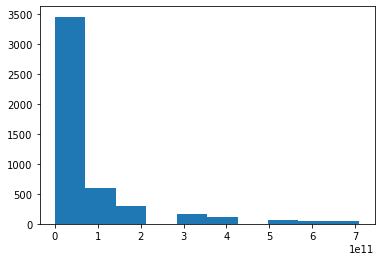

In [518]:
# Funding total USD
print(np.percentile(data_final['funding_total_usd'], 97.5))

plt.hist(data_final['funding_total_usd'][data_final['funding_total_usd'] < 800000000000])
print(len(data_final[data_final['funding_total_usd'] >= 800000000000.0]))
print(len(data_final))

69561028.64999995
119
96
4930


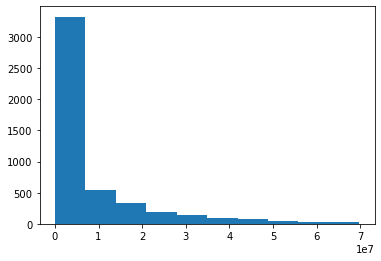

In [519]:
print(np.percentile(data_final['venture'], 97.5))

plt.hist(data_final['venture'][data_final['venture'] < 70000000.0])
print(len(data_final[data_final['venture'] > 70000000.0]))
print(len(data_final[(data_final['venture'] > 70000000.0) & 
               (data_final['funding_total_usd'] > 800000000000.0)]))
print(len(data_final))

In [520]:
data_lr = data_final[(data_final['venture'] < 70000000.0) & 
                     (data_final['funding_total_usd'] < 800000000000.0)].reset_index(drop=True)

In [521]:
X_ac_lr = data_lr.drop(columns=['status', 'name', 'country_code', 
                                'state_code', 'city'], axis=1)

encoder = LabelEncoder()
y_ac_lr = pd.Series(encoder.fit_transform(data_lr['status'])) 
# acquired is 0, closed is 1

y_ac_lr.value_counts(normalize=True)

0    0.588742
1    0.411258
dtype: float64

## Baseline Model

In [522]:
X_train_processed, X_train_scaled, X_test_processed, \
X_test_scaled, y_train, y_test = train_test_preprocess(X_ac_lr, y_ac_lr)

In [523]:
train_test_check(X_train_processed, X_train_scaled, X_test_processed, 
                 X_test_scaled, y_train, y_test)

There are 83 features in train set
There are 83 features in test set


There are 83 features in train set (scaled)
There are 83 features in test set (scaled)


y_train is a Series with 3570 values


target breakdown:  0    0.581793
1    0.418207
dtype: float64


,market_Advertising,market_Analytics,market_Android,market_Apps,market_Automotive,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,round_A,round_B,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,founded_month,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.331507,10,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4400000.0,5000000.0,0.0,0.0,0.0,0.0,0.0,0.000000,5,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498630,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.947945,6,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.241096,1,0


,market_Advertising,market_Analytics,market_Android,market_Apps,market_Automotive,market_Biotechnology,market_Clean Technology,market_Cloud Computing,market_Consulting,market_Curated Web,...,round_A,round_B,round_C,round_D,round_E,round_F,round_G,time_to_first_funding,founded_month,international
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.595690,10,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.097778,0.079365,0.0,0.0,0.0,0.0,0.0,0.579626,5,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.222222,0.000000,0.0,0.0,0.0,0.0,0.0,0.585642,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.591062,6,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.000000,0.0,0.0,0.0,0.0,0.0,0.594599,1,0


In [524]:
correlation_check(X_train_processed)

,cc
pairs,
"(funding_total_usd, venture)",0.914405
"(venture, round_B)",0.611358
"(venture, round_C)",0.604260
"(region_other, international)",0.567555
"(funding_total_usd, round_C)",0.562303
"(round_B, funding_total_usd)",0.554304
"(funding_rounds, venture)",0.552203
"(funding_total_usd, funding_rounds)",0.517989
"(region_other, region_SF Bay Area)",0.504931


In [525]:
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [526]:
y_hat_train = baseline_model.predict(X_train_scaled)
y_hat_test = baseline_model.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.6269256530475552
Testing Recall:  0.5956989247311828


Training F1:  0.6582278481012658
Testing F1:  0.604143947655398


ROC AUC:  0.6773260463876298
PR AUC:  0.5229138248539754


Training Accuracy:  0.7277310924369748
Testing Accuracy:  0.6952141057934509


### Baseline Analysis

* point A
* point B
* point C

### Grid Search on Baseline**

In [527]:
param_grid = {'penalty':['l2', None],
              'solver':['lbfgs', 'sag'],
              'C': [1.0, 1e12], 
              'class_weight': [None, 'balanced']
             }

In [528]:
grid_logreg = GridSearchCV(baseline_model, param_grid, cv = 5, 
                           scoring='recall') # macro or weighted
grid_logreg.fit(X_train_scaled, y_train)
grid_logreg.best_params_

{'C': 1000000000000.0,
 'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [529]:
y_preds_grid_lr_train = grid_logreg.predict(X_train_scaled)
y_preds_grid_lr = grid_logreg.predict(X_test_scaled)

print_scores(y_train, y_preds_grid_lr_train, y_test, y_preds_grid_lr)

Training Recall:  0.7675820495646349
Testing Recall:  0.7526881720430108


Training F1:  0.7009174311926605
Testing F1:  0.6616257088846881


ROC AUC:  0.708988714120679
PR AUC:  0.5408085437239796


Training Accuracy:  0.7260504201680672
Testing Accuracy:  0.6994122586062133


In [530]:
## Top coefficients
lr = LogisticRegression(random_state=42, class_weight='balanced', 
                        solver='lbfgs', C=1e12, penalty='l2')
lr.fit(X_train_scaled, y_train)

coef_df = pd.DataFrame(lr.coef_, columns=X_train_scaled.columns).transpose()
coef_df.to_csv('coef_logreg.csv')

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:20]

,coef,coef_abs
time_to_first_funding,-14.647481,14.647481
private_equity,-3.980899,3.980899
venture,-3.631479,3.631479
funding_rounds,-3.303331,3.303331
seed,-3.140217,3.140217
undisclosed,-3.132247,3.132247
convertible_note,2.843864,2.843864
funding_total_usd,2.159750,2.159750
market_Clean Technology,2.135076,2.135076
debt_financing,-1.698484,1.698484


In [531]:
X_train_scaled['private_equity'].value_counts() 
# vast majority of observations are 0, so coefficient probably isn't
# as important as its ranking implies

0.000000    3529
0.026667       2
0.932000       1
0.006667       1
0.800000       1
0.133333       1
0.126667       1
0.933333       1
0.011106       1
0.840000       1
0.046667       1
0.033333       1
0.123335       1
0.022267       1
0.160000       1
0.533333       1
0.960000       1
0.000173       1
1.000000       1
0.408116       1
0.148482       1
0.529627       1
0.042667       1
0.248854       1
0.186667       1
0.252775       1
0.019813       1
0.053333       1
0.074248       1
0.060000       1
0.154667       1
0.240000       1
0.087976       1
0.066667       1
0.005051       1
0.081411       1
0.244853       1
0.624849       1
0.724281       1
0.006000       1
0.120000       1
Name: private_equity, dtype: int64

## Custom Pipeline

In [532]:
scores = pd.DataFrame(columns = ['recall_train', 'recall_test', 'f1_train', 
                                 'f1_test', 'accuracy_train', 'accuracy_test', 
                                 'roc_auc', 'pr_auc', 'params'])

In [533]:
# creates a data frame with various scores for each model
def customPipe(model, model_name, X, y):
    X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
    y_train, y_test = train_test_preprocess(X, y)
    
    if ('lr' in model_name) | ('knn' in model_name):
        model.fit(X_train_scaled, y_train)
        y_hat_train = model.predict(X_train_scaled)
        y_hat_test = model.predict(X_test_scaled)

    else:
        model.fit(X_train_processed, y_train)
        y_hat_train = model.predict(X_train_processed)
        y_hat_test = model.predict(X_test_processed)
    
    r_train, r_test, f1_train, f1_test, ac_train, ac_test, roc_auc, pr_auc = \
    return_scores(y_train, y_hat_train, y_test, y_hat_test)
    
    score_list = []
    score_list.extend((r_train, r_test, f1_train, f1_test, 
                       ac_train, ac_test, roc_auc, pr_auc, str(model)))
    
    scores.loc[model_name] = score_list
    return scores

In [534]:
# model inputs
lr = LogisticRegression(random_state=42, class_weight='balanced', 
                        solver='lbfgs', C=1e12, penalty='l2')
rf = RandomForestClassifier(random_state=42)
dtc = DecisionTreeClassifier(random_state=42)
ext = ExtraTreesClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
knn = KNeighborsClassifier()

In [535]:
# running the function
customPipe(lr, 'lr', X_ac_lr, y_ac_lr)
customPipe(rf, 'rf', X_ac, y_ac)
customPipe(dtc, 'dtc', X_ac, y_ac)
customPipe(ext, 'ext', X_ac, y_ac)
customPipe(xgb, 'xgb', X_ac, y_ac)
customPipe(knn, 'knn', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.767582,0.752688,0.700917,0.661626,0.726050,0.699412,0.708989,0.540809,"LogisticRegression(C=1000000000000.0, class_we..."
rf,1.000000,0.589178,1.000000,0.643326,1.000000,0.735604,0.712164,0.583655,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.571142,1.000000,0.617551,1.000000,0.713706,0.690884,0.557465,ExtraTreesClassifier(random_state=42)
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()


Looking at recall and accuracy, the Random Forest and XGBoost models seem to yield the best scores. Will hyper tune each of these models.

In [536]:
# storing dataframe for easy access
scores_base = scores # models pre hyper parameter tuning

## Other Models - Hypertuning

### Random Forest

In [537]:
rf = RandomForestClassifier(random_state=42)

# Initial search
rf_param_grid = {
    'criterion':['gini','entropy','log_loss'],
    'max_depth':[8,12,20],
    'min_samples_leaf': [5,10],
    'class_weight': [None, 'balanced']
}

# Fine tuning
rf_param_grid2 = {
    'criterion':['gini'],
    'max_depth':[20,25],
    'min_samples_leaf': [10,15,20],
    'class_weight': ['balanced'],
    'n_estimators': [100, 200]
}

grid_rfc = GridSearchCV(rf, rf_param_grid2, cv = 5, scoring='recall') 
grid_rfc.fit(X_train_processed, y_train)

grid_rfc.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 20,
 'n_estimators': 200}

In [538]:
rf_best = RandomForestClassifier(random_state = 42, class_weight='balanced', 
                                 criterion='gini', max_depth=20, #12
                                 min_samples_leaf=15, n_estimators=100) #100
customPipe(rf_best, 'rf_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.767582,0.752688,0.700917,0.661626,0.726050,0.699412,0.708989,0.540809,"LogisticRegression(C=1000000000000.0, class_we..."
rf,1.000000,0.589178,1.000000,0.643326,1.000000,0.735604,0.712164,0.583655,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.571142,1.000000,0.617551,1.000000,0.713706,0.690884,0.557465,ExtraTreesClassifier(random_state=42)
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.726967,0.703407,0.712591,0.690945,0.764133,0.745337,0.738624,0.597587,RandomForestClassifier(class_weight='balanced'...


#### Feature Importance

In [539]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_processed.columns, rf_best.feature_importances_):
    feats[feature] = importance #add the name/value pair 

feats_rf = pd.DataFrame(feats.items())

feats_rf.columns = ['col', 'feat_importance']
feats_rf = feats_rf.sort_values(by=['feat_importance'], ascending=False)
feats_rf_20 = feats_rf[:20]
feats_rf_30 = feats_rf[:30]

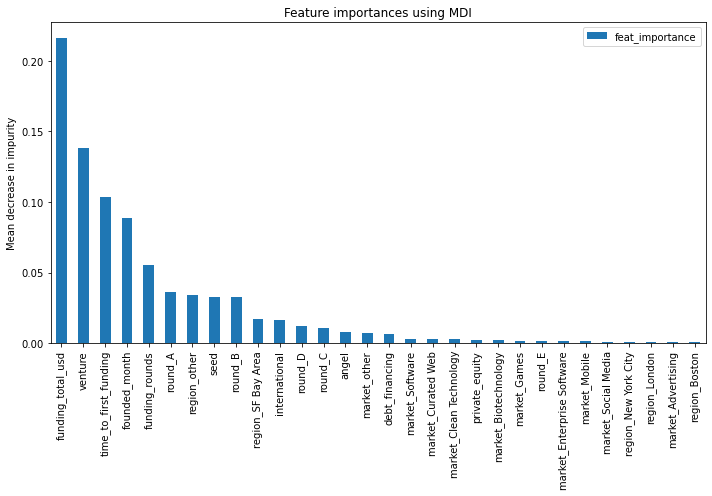

In [540]:
fig, ax = plt.subplots(figsize = (10,7))
feats_rf_30.plot.bar(ax=ax) # yerr=std, 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feats_rf_30['col'])
fig.tight_layout()

In [541]:
list(feats_rf['col'][:10])

['funding_total_usd',
 'venture',
 'time_to_first_funding',
 'founded_month',
 'funding_rounds',
 'round_A',
 'region_other',
 'seed',
 'round_B',
 'region_SF Bay Area']

### XG Boost*

In [542]:
# 45+ runtime
xgb = XGBClassifier(random_state=42)

# initial grid search
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [4,6,8],
    'min_child_weight': [3,5,7],
    'subsample': [0.5, 0.7],
    'scale_pos_weight':[1.5,2]
}

# fine tuning
xgb_param_grid2 = {
    'learning_rate': [0.1],
    'max_depth': [1,2,4],
    'min_child_weight': [1,5,10],
    'subsample': [0.7, 0.9],
    'scale_pos_weight':[2]
}

grid_xgb = GridSearchCV(xgb, xgb_param_grid2, cv = 5, scoring='recall') 
grid_xgb.fit(X_train_processed, y_train)

grid_xgb.best_params_

{'learning_rate': 0.1,
 'max_depth': 1,
 'min_child_weight': 10,
 'scale_pos_weight': 2,
 'subsample': 0.7}

In [543]:
xgb_best = XGBClassifier(random_state=42, max_depth=1, min_child_weight=10, 
                         subsample=0.7, learning_rate=0.2, scale_pos_weight=2)

customPipe(xgb_best, 'xgb_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.767582,0.752688,0.700917,0.661626,0.726050,0.699412,0.708989,0.540809,"LogisticRegression(C=1000000000000.0, class_we..."
rf,1.000000,0.589178,1.000000,0.643326,1.000000,0.735604,0.712164,0.583655,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.571142,1.000000,0.617551,1.000000,0.713706,0.690884,0.557465,ExtraTreesClassifier(random_state=42)
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.726967,0.703407,0.712591,0.690945,0.764133,0.745337,0.738624,0.597587,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.806994,0.797595,0.710059,0.695197,0.734920,0.716951,0.729860,0.573312,"XGBClassifier(base_score=0.5, booster='gbtree'..."


#### Feature Importance

In [544]:
xgb_best.fit(X_train_processed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=1,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [545]:
f = 'gain' # importance type
feat_imp = xgb_best.get_booster().get_score(importance_type= f)
feats_xg = pd.DataFrame(sorted(feat_imp.items(), key=lambda item: item[1], 
                            reverse=True))
feats_xg.columns = ['col', 'feat_importance']
feats_xg[:15]

,col,feat_importance
0,funding_total_usd,104.421405
1,region_other,40.776967
2,funding_rounds,38.640555
3,time_to_first_funding,34.493131
4,market_other,23.375635
5,venture,21.451009
6,market_Enterprise Software,20.053893
7,market_Clean Technology,18.556825
8,international,17.840616
9,region_SF Bay Area,16.663320


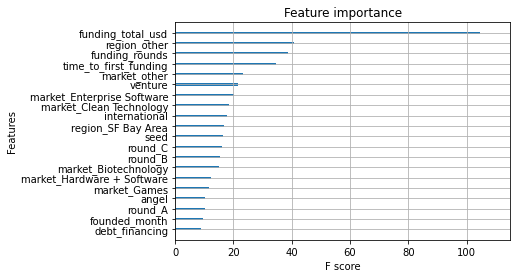

In [546]:
from xgboost import plot_importance
plot_importance(xgb_best, max_num_features=20, importance_type=f, 
                show_values=False)
plt.show()

### ExtraTrees

In [547]:
ext_param_grid = {'criterion':['entropy','gini'],
              'max_depth':[15,20,25],
              'min_samples_leaf': [1,5],
              'class_weight': ['balanced'],
              'max_features': ['auto']
             }

ext = ExtraTreesClassifier(random_state=42)

grid_ext = GridSearchCV(ext, ext_param_grid, cv = 5, scoring='recall') 
grid_ext.fit(X_train_processed, y_train)

grid_ext.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 5}

In [548]:
ext_grid = ExtraTreesClassifier(random_state=42, class_weight='balanced',
                                criterion='gini', max_depth= 25,
                                max_features='auto', min_samples_leaf= 5)
customPipe(ext_grid, 'ext_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.767582,0.752688,0.700917,0.661626,0.726050,0.699412,0.708989,0.540809,"LogisticRegression(C=1000000000000.0, class_we..."
rf,1.000000,0.589178,1.000000,0.643326,1.000000,0.735604,0.712164,0.583655,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.571142,1.000000,0.617551,1.000000,0.713706,0.690884,0.557465,ExtraTreesClassifier(random_state=42)
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.726967,0.703407,0.712591,0.690945,0.764133,0.745337,0.738624,0.597587,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.806994,0.797595,0.710059,0.695197,0.734920,0.716951,0.729860,0.573312,"XGBClassifier(base_score=0.5, booster='gbtree'..."
ext_best,0.781439,0.711423,0.729212,0.664172,0.766567,0.708840,0.709254,0.559867,"ExtraTreesClassifier(class_weight='balanced', ..."


### Decision Tree***

In [549]:
dtc_param_grid = {'criterion':['gini','entropy'],
                  'max_depth':[5,10,15],
                  'min_samples_leaf': [15,20,25],
                  'class_weight': [None, 'balanced']
             }

dtc = DecisionTreeClassifier(random_state=42)

grid_dtc = GridSearchCV(dtc, dtc_param_grid, cv = 5, scoring='recall') 
grid_dtc.fit(X_train_processed, y_train)

grid_dtc.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 25}

In [550]:
dtc_best = DecisionTreeClassifier(random_state=42, class_weight='balanced',
                                  criterion='gini', max_depth= 5,
                                  min_samples_leaf= 20)

dtc_best.fit(X_train_processed, y_train)
customPipe(dtc_best, 'dtc_best', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.767582,0.752688,0.700917,0.661626,0.726050,0.699412,0.708989,0.540809,"LogisticRegression(C=1000000000000.0, class_we..."
rf,1.000000,0.589178,1.000000,0.643326,1.000000,0.735604,0.712164,0.583655,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.571142,1.000000,0.617551,1.000000,0.713706,0.690884,0.557465,ExtraTreesClassifier(random_state=42)
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.726967,0.703407,0.712591,0.690945,0.764133,0.745337,0.738624,0.597587,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.806994,0.797595,0.710059,0.695197,0.734920,0.716951,0.729860,0.573312,"XGBClassifier(base_score=0.5, booster='gbtree'..."
ext_best,0.781439,0.711423,0.729212,0.664172,0.766567,0.708840,0.709254,0.559867,"ExtraTreesClassifier(class_weight='balanced', ..."
dtc_best,0.797579,0.773547,0.707637,0.683791,0.734920,0.710462,0.720561,0.565597,DecisionTreeClassifier(class_weight='balanced'...


#### Feature Importance

In [551]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_processed.columns, dtc_best.feature_importances_):
    feats[feature] = importance #add the name/value pair 

feats_dtc = pd.DataFrame(feats.items())

feats_dtc.columns = ['col', 'feat_importance']
feats_dtc = feats_dtc.sort_values(by=['feat_importance'], ascending=False)
feats_dtc_30 = feats_dtc[:30]

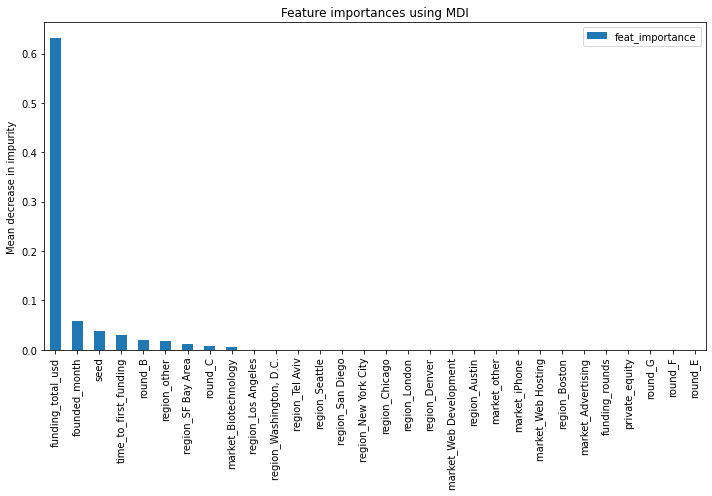

In [552]:
fig, ax = plt.subplots(figsize = (10,7))
feats_dtc_30.plot.bar(ax=ax) # yerr=std, 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feats_dtc_30['col'])
fig.tight_layout()

## Final Model

* XG Boost is the best model, with ~81% recall, 71% accuracy and 73% AUC
* Now that we have narrowed down the best models, we will run then with reduced features & SMOTE to see if that generates any improvement

In [553]:
X_train_processed, X_train_scaled, X_test_processed, \
X_test_scaled, y_train, y_test = train_test_preprocess(X_ac, y_ac)

### Feature Reduction

In [554]:
# top 20 features
X_train_xg = X_train_processed[list(feats_xg['col'][:20])]
X_train_dtc = X_train_processed[list(feats_dtc['col'][:20])]

X_test_xg = X_test_processed[list(feats_xg['col'][:20])]
X_test_dtc = X_test_processed[list(feats_dtc['col'][:20])]

In [555]:
# XG Boost
final_model = XGBClassifier(random_state=42, max_depth=1, min_child_weight=10, 
                            subsample=0.7, learning_rate=0.2, scale_pos_weight=2)

final_model.fit(X_train_xg, y_train)

y_hat_train = final_model.predict(X_train_xg)
y_hat_test = final_model.predict(X_test_xg)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7794216543375925
Testing Recall:  0.7775551102204409


Training F1:  0.6909090909090909
Testing F1:  0.6867256637168141


ROC AUC:  0.7232462199603567
PR AUC:  0.5681406268836522


Training Accuracy:  0.7195022991614822
Testing Accuracy:  0.7128953771289538


In [556]:
# Decision Trees - 2nd place
final_model = dtc_best
final_model.fit(X_train_dtc, y_train)

y_hat_train = final_model.predict(X_train_dtc)
y_hat_test = final_model.predict(X_test_dtc)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.6778749159381304
Testing Recall:  0.6533066132264529


Training F1:  0.6845500848896435
Testing F1:  0.6612576064908722


ROC AUC:  0.7169802820900657
PR AUC:  0.5776345895793111


Training Accuracy:  0.7487151744657831
Testing Accuracy:  0.7291159772911597


Feature reduction doesn't improve the models.

### SMOTE

In [557]:
#Using SMOTE to further reduce class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_processed, y_train) 

In [558]:
final_model_smote = XGBClassifier(random_state=42, max_depth=1, min_child_weight=10, 
                                  subsample=0.7, learning_rate=0.2)

final_model_smote.fit(X_train_resampled, y_train_resampled)

y_hat_train = final_model_smote.predict(X_train_resampled)
y_hat_test = final_model_smote.predict(X_test_processed)

print_scores(y_train_resampled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7737556561085973
Testing Recall:  0.7474949899799599


Training F1:  0.7687120701281187
Testing F1:  0.7037735849056603


ROC AUC:  0.7456820998946121
PR AUC:  0.5991873412046519


Training Accuracy:  0.7671945701357467
Testing Accuracy:  0.7453365774533658


### Model Selection

In [559]:
final_model = XGBClassifier(random_state=42, max_depth=1, min_child_weight=10, 
                            subsample=0.7, learning_rate=0.2, scale_pos_weight=2)

customPipe(final_model, 'final_model', X_ac, y_ac)

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
lr,0.767582,0.752688,0.700917,0.661626,0.726050,0.699412,0.708989,0.540809,"LogisticRegression(C=1000000000000.0, class_we..."
rf,1.000000,0.589178,1.000000,0.643326,1.000000,0.735604,0.712164,0.583655,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
ext,1.000000,0.571142,1.000000,0.617551,1.000000,0.713706,0.690884,0.557465,ExtraTreesClassifier(random_state=42)
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
rf_best,0.726967,0.703407,0.712591,0.690945,0.764133,0.745337,0.738624,0.597587,RandomForestClassifier(class_weight='balanced'...
xgb_best,0.806994,0.797595,0.710059,0.695197,0.734920,0.716951,0.729860,0.573312,"XGBClassifier(base_score=0.5, booster='gbtree'..."
ext_best,0.781439,0.711423,0.729212,0.664172,0.766567,0.708840,0.709254,0.559867,"ExtraTreesClassifier(class_weight='balanced', ..."
dtc_best,0.797579,0.773547,0.707637,0.683791,0.734920,0.710462,0.720561,0.565597,DecisionTreeClassifier(class_weight='balanced'...


In [560]:
# storing dataframe for easy access
scores_final = scores
scores_final.to_csv('final_scores.csv')
scores_final.sort_values(by=['recall_test'], ascending=False)[1:]

,recall_train,recall_test,f1_train,f1_test,accuracy_train,accuracy_test,roc_auc,pr_auc,params
final_model,0.806994,0.797595,0.710059,0.695197,0.734920,0.716951,0.729860,0.573312,"XGBClassifier(base_score=0.5, booster='gbtree'..."
dtc_best,0.797579,0.773547,0.707637,0.683791,0.734920,0.710462,0.720561,0.565597,DecisionTreeClassifier(class_weight='balanced'...
lr,0.767582,0.752688,0.700917,0.661626,0.726050,0.699412,0.708989,0.540809,"LogisticRegression(C=1000000000000.0, class_we..."
ext_best,0.781439,0.711423,0.729212,0.664172,0.766567,0.708840,0.709254,0.559867,"ExtraTreesClassifier(class_weight='balanced', ..."
rf_best,0.726967,0.703407,0.712591,0.690945,0.764133,0.745337,0.738624,0.597587,RandomForestClassifier(class_weight='balanced'...
xgb,0.933423,0.607214,0.927188,0.641949,0.941033,0.725872,0.706877,0.572414,"XGBClassifier(base_score=0.5, booster='gbtree'..."
rf,1.000000,0.589178,1.000000,0.643326,1.000000,0.735604,0.712164,0.583655,RandomForestClassifier(random_state=42)
dtc,1.000000,0.577154,1.000000,0.588957,1.000000,0.673966,0.658468,0.518143,DecisionTreeClassifier(random_state=42)
knn,0.709482,0.577154,0.714528,0.576577,0.771977,0.656934,0.644163,0.503568,KNeighborsClassifier()
ext,1.000000,0.571142,1.000000,0.617551,1.000000,0.713706,0.690884,0.557465,ExtraTreesClassifier(random_state=42)


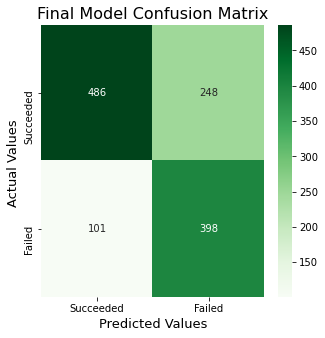

In [561]:
# visualizing predictions

y_hat_test = final_model.predict(X_test_processed)

conf_matrix = confusion_matrix(y_test, y_hat_test)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

ax.set_title('Final Model Confusion Matrix', fontsize=16);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Succeeded','Failed'])
ax.yaxis.set_ticklabels(['Succeeded','Failed'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Final Analysis & Visualizations

Text(0.5, 0.98, 'Model Performance')

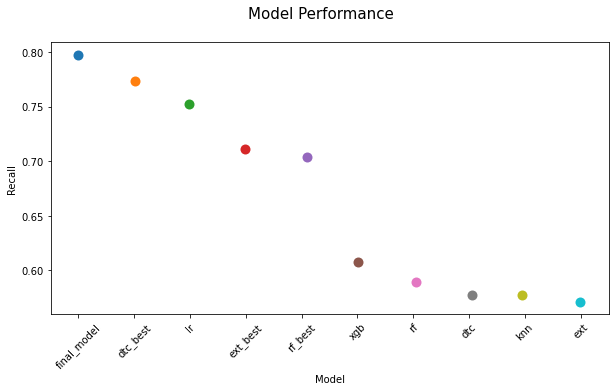

In [562]:
## Model Comparison
scores_viz = scores_final.sort_values(by=['recall_test'], ascending=False)[1:].reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
sns.stripplot(x="index", y="recall_test", data=scores_viz, size=10)
plt.xticks(rotation = 45)
ax.set_xlabel("Model", fontsize=10)
ax.set_ylabel("Recall", fontsize=10)
fig.suptitle("Model Performance", fontsize=15)

In [563]:
## Visualizing Important Features

In [564]:
df = data_final2
df['int_category'] = ['international' if x==1 else 'U.S.' for x in df['international']]
df['one_funding_round'] = ['one' if x==1 else 'multiple' for x in df['funding_rounds']]

df_box = df[(df['venture'] < 40000000.0)]

cmap = sns.diverging_palette(130, 50, as_cmap=True)

<Figure size 360x360 with 0 Axes>

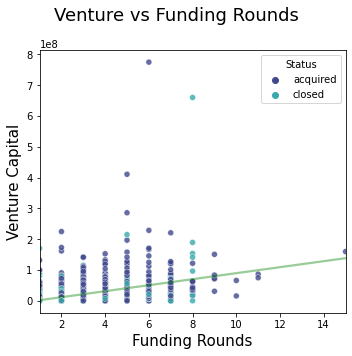

In [565]:
# setting up the figure with a single subplot
fig = plt.figure(figsize=(5, 5)) 
fig, ax = plt.subplots(figsize=(5, 5))
# scatterplot using seaborn
plot = sns.scatterplot(x='funding_rounds', y='venture', data=df,
hue=df.status, legend='full', alpha = 0.8, palette='mako')
# adding regression line using seaborn regplot
sns.regplot(data=df, x='funding_rounds', y='venture', scatter=False, 
            ax=ax, ci=False, color='g', line_kws={'alpha':0.4})

# updating figure title, adding labels for x- and y-axis
fig.suptitle("Venture vs Funding Rounds", fontsize=18)
ax.set_xlabel("Funding Rounds", fontsize=15)
ax.set_ylabel("Venture Capital", fontsize=15)
# setting legend title
ax.get_legend().set_title("Status")
# getting everything to fit nicely on the plot
plt.tight_layout()

<AxesSubplot:xlabel='venture', ylabel='status'>

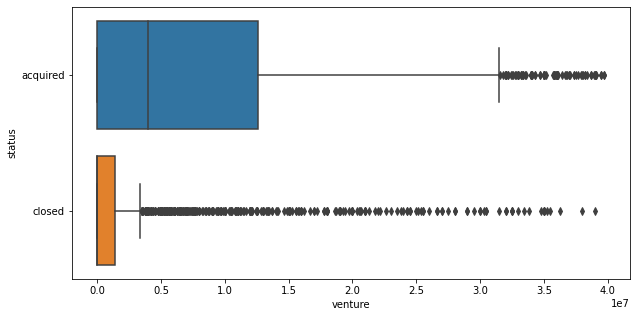

In [566]:
df_box = df[(df['venture'] < 40000000.0)]
#df_box = df[(df['funding_total_usd'] < 1000000.0)]

plt.figure(figsize=(10,5))
sns.boxplot(x=df_box['venture'], y=df_box['status'])

U.S.             3143
international    1443
Name: int_category, dtype: int64

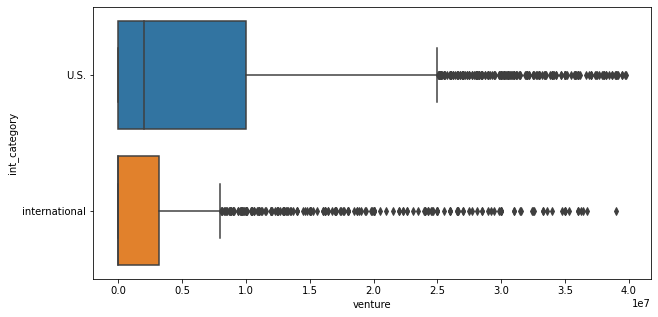

In [567]:
plt.figure(figsize=(10,5))

sns.boxplot(x=df_box['venture'], y=df_box['int_category'])

df_box['int_category'].value_counts()

<AxesSubplot:xlabel='funding_total_usd', ylabel='status'>

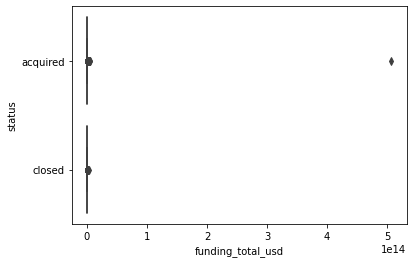

In [568]:
sns.boxplot(x=df_box['funding_total_usd'], y=df_box['status'])

Text(0.5, 1.0, 'Seed Funding')

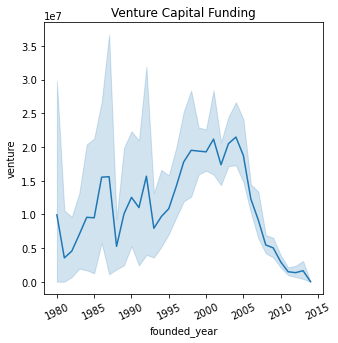

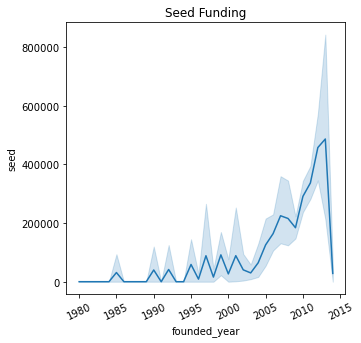

In [569]:
plt.figure(figsize=(5,5))
plt.title('Venture Capital Funding')
sns.lineplot(x = "founded_year", y = "venture", data = df)
plt.xticks(rotation = 25)

plt.figure(figsize=(5,5))
sns.lineplot(x = "founded_year", y = "seed", data = df)
plt.xticks(rotation = 25)
plt.title('Seed Funding')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'other'),
  Text(1, 0, 'Software'),
  Text(2, 0, 'Curated Web'),
  Text(3, 0, 'Mobile'),
  Text(4, 0, 'Enterprise Software'),
  Text(5, 0, 'Biotechnology'),
  Text(6, 0, 'Advertising'),
  Text(7, 0, 'Games'),
  Text(8, 0, 'E-Commerce'),
  Text(9, 0, 'Social Media'),
  Text(10, 0, 'Hardware + Software')])

<Figure size 720x720 with 0 Axes>

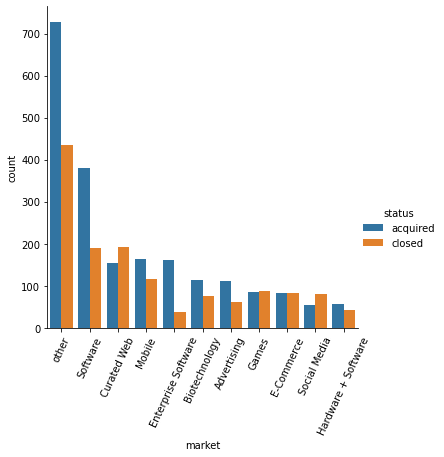

In [570]:
# top 10 markets

#print(set(df['market'][df['market'].map(df['market'].value_counts()) >= 100]))
df['market'].value_counts()[1:11]
top10_mkt = list(set(df['market'][df['market'].map(df['market'].value_counts()) >= 100]))
top10_mkt

plt.figure(figsize=(10,10))
sns.catplot(x='market',hue='status',data=df[df['market'].isin(top10_mkt)],
            kind="count", 
            order = df['market'][df['market'].isin(top10_mkt)].value_counts().index)
plt.xticks(rotation = 65)

SF Bay Area         1250
New York City        338
Boston               260
Los Angeles          186
London               146
Seattle              143
Washington, D.C.      85
Chicago               85
Austin                84
San Diego             77
Name: region, dtype: int64


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'other'),
  Text(1, 0, 'SF Bay Area'),
  Text(2, 0, 'New York City'),
  Text(3, 0, 'Boston'),
  Text(4, 0, 'Los Angeles'),
  Text(5, 0, 'London'),
  Text(6, 0, 'Seattle'),
  Text(7, 0, 'Washington, D.C.'),
  Text(8, 0, 'Chicago'),
  Text(9, 0, 'Austin'),
  Text(10, 0, 'San Diego')])

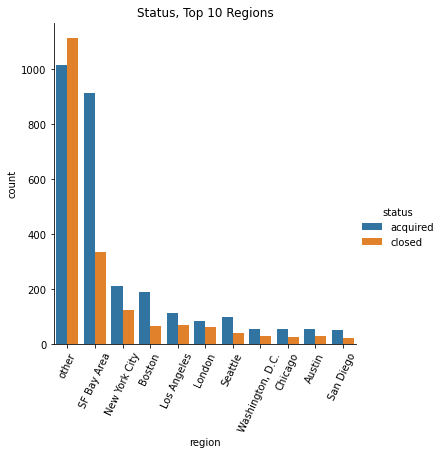

In [571]:
print(df['region'].value_counts()[1:11])
top10_reg = list(set(df['region'][df['region'].map(df['region'].value_counts()) >= 77]))
top10_reg

# fig= plt.figure(figsize=(10,5))
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_xlabel("Region", fontsize=10)
# ax.set_ylabel("Count", fontsize=10)
# fig.suptitle("Status, Top 10 Regions", fontsize=15)

sns.catplot(x='region',hue='status',data=df[df['region'].isin(top10_reg)],
            kind="count", 
            order = df['region'][df['region'].isin(top10_reg)].value_counts().index)
plt.title('Status, Top 10 Regions')
plt.xticks(rotation = 65)

<AxesSubplot:xlabel='venture', ylabel='status'>

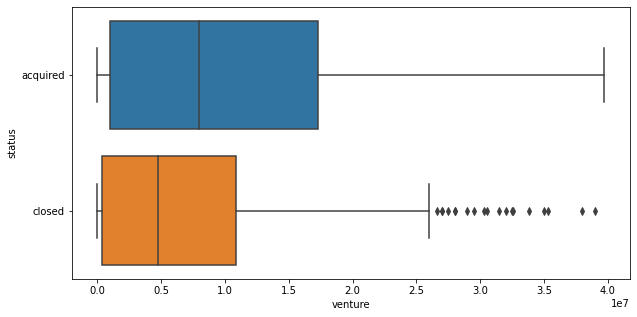

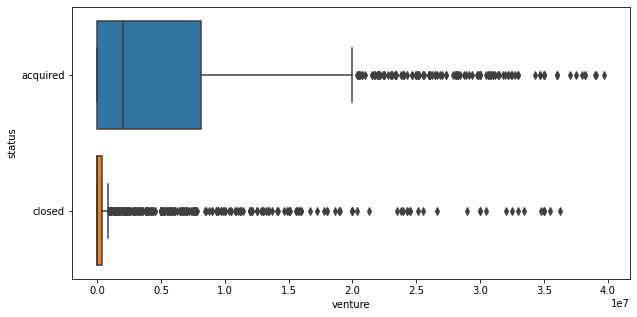

In [572]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df_box['venture'][df_box['founded_year'] < 2005], 
            y=df_box['status'][df_box['founded_year'] < 2005])

plt.figure(figsize=(10,5))
sns.boxplot(x=df_box['venture'][df_box['founded_year'] >= 2005], 
            y=df_box['status'][df_box['founded_year'] >= 2005])

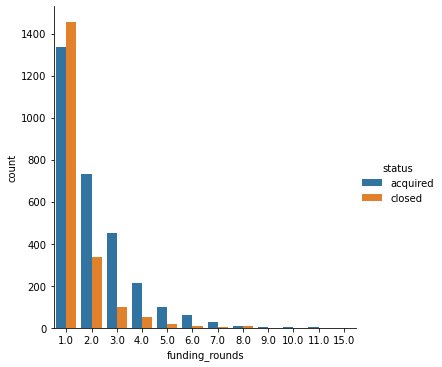

In [573]:
# number of funding rounds
df['funding_rounds'].value_counts()

# acquired or closed by number of funding rounds

sns.catplot(x='funding_rounds',hue='status', data=df, kind="count") 

<AxesSubplot:xlabel='venture', ylabel='status'>

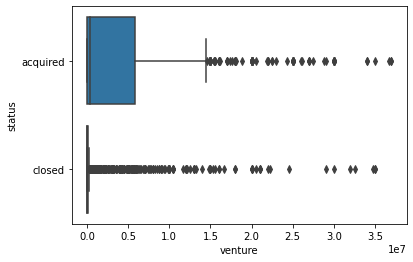

In [574]:
# more than one funding round
df_ofr = df_box[df_box['one_funding_round']=='one']
df_mfr = df_box[df_box['one_funding_round']=='multiple']
sns.boxplot(x='venture', y='status', data=df_ofr)

<AxesSubplot:xlabel='venture', ylabel='status'>

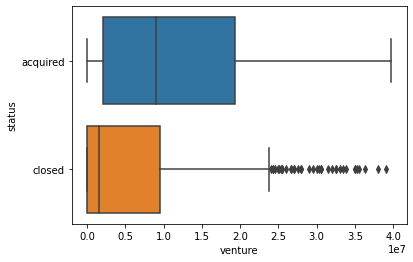

In [575]:
sns.boxplot(x='venture', y='status', data=df_mfr)

<AxesSubplot:xlabel='one_funding_round', ylabel='count'>

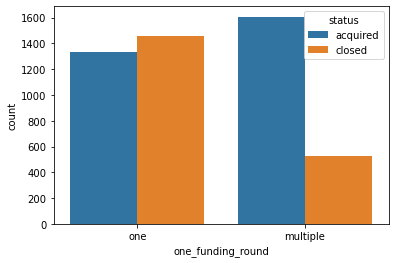

In [576]:
sns.countplot(x='one_funding_round',hue='status', data=df, orient='v') 